# Template Matching

In [6]:
import numpy as np
from skimage import io, util, filters, color, transform
import cv2
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from utils import *

## Helper funtions

In [7]:
def vconcat_two_images(imgA, imgB):
    rowsA, colsA = imgA.shape[:2]
    rowsB, colsB = imgB.shape[:2]
    if len(imgA.shape) != len(imgB.shape):
        raise ValueError("Non-matching array dimensions!")
    elif len(imgA.shape) == 3 and imgA.shape[-1] != imgB.shape[-1]:
        raise ValueError("Non-matching channel size!")
    if imgA.dtype != imgB.dtype:
        raise ValueError("Non-matching data types!")
    composite_image_rows = max(rowsA, rowsB)
    composite_image_cols = colsA + colsB
    composite_image = np.zeros((composite_image_rows, composite_image_cols))
    composite_image[:rowsA, :colsA] = imgA
    composite_image[:rowsB, colsA:] = imgB
    return composite_image

## Load images

In [27]:
# logos and their 4 possible rotations
pepsi_logo = io.imread("../img/pepsi_logo.png")
cocacola_logo = io.imread("../img/cocacola_logo.png")
temp_imgs = [
    pepsi_logo,
    util.img_as_ubyte(transform.rotate(pepsi_logo, -90, resize=True)),
    util.img_as_ubyte(transform.rotate(pepsi_logo, 90, resize=True)),
    util.img_as_ubyte(transform.rotate(pepsi_logo, 180, resize=True)),
    cocacola_logo,
    util.img_as_ubyte(transform.rotate(cocacola_logo, -90, resize=True)),
    util.img_as_ubyte(transform.rotate(cocacola_logo, 90, resize=True)),
    util.img_as_ubyte(transform.rotate(cocacola_logo, 180, resize=True)),
]
# source image in which inference will be done
src_img = io.imread("../img/cocacola_and_pepsi.jpeg")

In [28]:
# take only the contours of the templates, and make sure dtype is uint8
for i in range(len(temp_imgs)):
    if len(temp_imgs[i].shape) == 2: # it's already grayscale
        pass
    elif temp_imgs[i].shape[2] == 4:
        gray = color.rgb2gray(color.rgba2rgb(temp_imgs[i]))
    elif temp_imgs[i].shape[2] == 3:
        gray = color.rgb2gray(temp_imgs[i])
    # gray = filters.sobel(gray)
    temp_imgs[i] = gray.astype(np.float32)

# take only the contours of the source image, and make sure dtype is uint8
if len(src_img.shape) == 2: 
    pass # it's already grayscale
elif src_img.shape[2] == 4:
    src_img = color.rgb2gray(color.rgba2rgb(src_img))
elif src_img.shape[2] == 3:
    src_img = color.rgb2gray(src_img)
# src_img = filters.sobel(src_img)
src_img = src_img.astype(np.float32)

# testing below

2.11717576803494e-08 1.0 (221, 587) (664, 701)


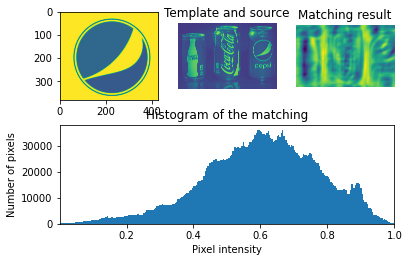

1.2400782622989936e-08 1.0 (160, 800) (1348, 752)


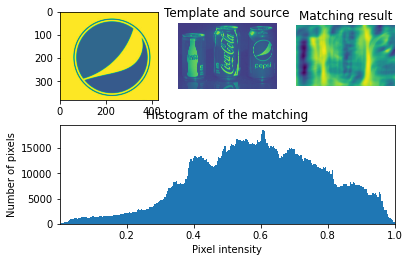

-1.3938098675225774e-08 1.0 (88, 631) (258, 204)


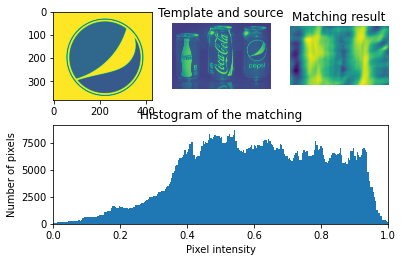

-1.8655846645287966e-08 0.9999999403953552 (25, 462) (208, 146)


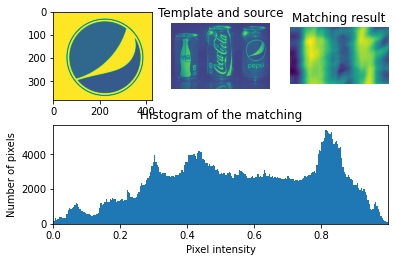

-4.042068013632161e-09 1.0 (0, 275) (151, 151)


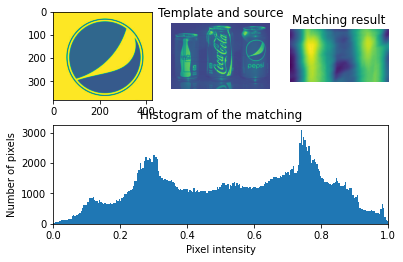

2.6586363333080953e-08 1.0 (267, 173) (96, 71)


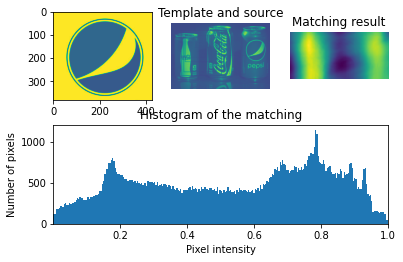

9.774776543736152e-09 1.0 (188, 56) (72, 100)


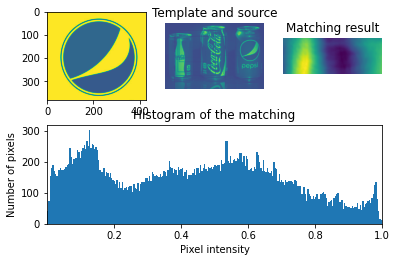

-8.071992851910181e-09 1.0 (172, 0) (63, 18)


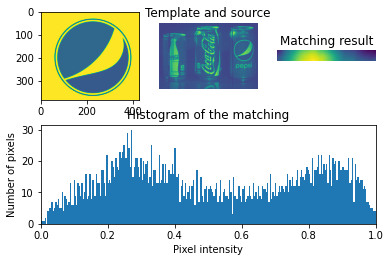

In [29]:
# look for a template match in the soruce image
current_template = temp_imgs[0]
for scale_row, scale_col, image in image_pyramid(src_img, current_template.shape[:2], fx=4/5, fy=4/5):
    # template matching
    res = cv2.matchTemplate(image, current_template, cv2.TM_CCOEFF_NORMED)
    cv2.normalize(res, res, 0, 1, cv2.NORM_MINMAX, -1)
    minVal, maxVal, minLoc, maxLoc = cv2.minMaxLoc(res, None)
    print(minVal, maxVal, minLoc, maxLoc)
    cv2.rectangle(
        image, 
        maxLoc, 
        (maxLoc[0] + current_template.shape[0], maxLoc[1] + current_template.shape[1]), 
        (0,255,0), 2, 8, 0 
    )

    # temp_and_src = vconcat_two_images(current_template, image)
    # display
    gs = gridspec.GridSpec(2, 3)
    fig = plt.figure()
    ax0 = fig.add_subplot(gs[0, 0])
    ax0.imshow(current_template)
    ax0.set_axis_off()

    ax1 = fig.add_subplot(gs[0, 1])
    ax1.imshow(image)
    ax1.set_title("Template and source")
    ax1.set_axis_off()

    ax2 = fig.add_subplot(gs[0, 2])
    ax2.set_title("Matching result")
    ax2.imshow(res)
    ax2.set_axis_off()
    
    ax_hist = fig.add_subplot(gs[1, :])
    ax_hist.hist(res.ravel(), bins=256)
    ax_hist.set_title("Histogram of the matching")
    ax_hist.set_xlabel('Pixel intensity')
    ax_hist.set_ylabel('Number of pixels')
    ax_hist.set_xlim(np.amin(res), np.amax(res))
    # fig.colorbar(res_ax)
    plt.show()

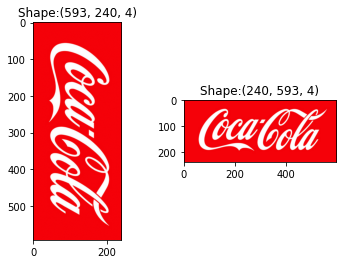

In [9]:
rotated_cocacola_logo = transform.rotate(io.imread("../img/cocacola_logo.png"), -90, resize=True)
cocacola_logo = io.imread("../img/cocacola_logo.png")
fig, ax = plt.subplots(nrows=1, ncols=2)
ax[0].imshow(rotated_cocacola_logo)
ax[0].set_title(f"Shape:{rotated_cocacola_logo.shape}")
ax[1].imshow(cocacola_logo)
ax[1].set_title(f"Shape:{cocacola_logo.shape}")
plt.show()

float64 0.0 0.71930185485845


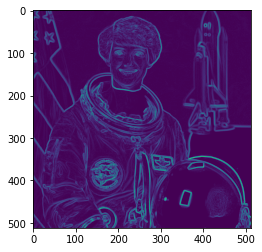

uint8 0 183


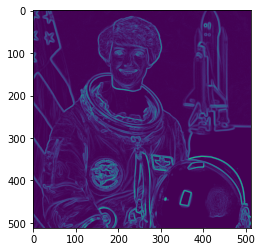

In [39]:
# functions return float64, but template matching needs uint8 or float32

from skimage.color import rgb2gray
from skimage import data
img = data.astronaut()
img_gray1 = rgb2gray(img)
img_gray1 = filters.sobel(img_gray1)
print(img_gray1.dtype, np.amin(img_gray1), np.amax(img_gray1))
plt.imshow(img_gray1)
plt.show()

img_gray2 = rgb2gray(img)
img_gray2 = filters.sobel(img_gray2)
img_gray2 *= 255
img_gray2 = img_gray2.astype(np.uint8)
print(img_gray2.dtype, np.amin(img_gray2), np.amax(img_gray2))
plt.imshow(img_gray2)
plt.show()